![Egeria Logo](https://raw.githubusercontent.com/odpi/egeria/master/assets/img/ODPi_Egeria_Logo_color.png)

### ODPi Egeria Hands-On Lab
# Egeria Servers and Metadata for Rex Development

## Introduction

This notebook will use one OMAG Server Platform to start a pair of OMAG Servers, both with local Repositories. One server will be used as the public data catalog which will store the metadata describing the schema of an asset - in our example this is a relational database with tables and columns. This server will have a graph repository.
The other server will be used to store metadata generated by a discovery process and has an in-memory repository. 

It is useful to have different types of repository to allow testing of Rex with repositories with different levels of support for graph queries. The graph repository has full support, whereas the in-memory repository only supports getEntityNeighborhood.

The real-world flow that we are emulating is:
* an asset owner on-boards the asset in the public data catalog, specifying the asset and connection to it
* the discvovery service runs and generates a discovery analysis report, plus an RFA to the stewardship server
* the stewardship server examines the report and for each DataField it creates the corresponding schema object in the public data catalog - and ties it to the DataField in the discovery report.

Rather than using 3 servers, this notebook operates with 2 - 
* the asset and its schema are stored in the "Schema Server" 
* the discovery report artefacts are stored in the "Report Server" 

When a schema artefact is created in the Schema Server a relationship is created between the artefact and the corresponding DataField in the Report Server. Because the DataField is homed by the Report Server we need to enable enterprise services in the Schema Server so that it can locate the DataField entity.

TODO - include picture!!
![CTS-Cohort.png](../images/RexDevCohort.png)
> **Figure 1:** Cohort for Rex Development

## Starting up the Egeria platform

Start one OMAG Server Platform on which to run both the servers. The following is expecting port 8088 but change it as necessary.

We also need Apache Zookeeper and Apache Kafka.  


In [1]:
import requests
import pprint
import json
import os
import time

platformURL = os.environ.get('platformURL','http://localhost:8088') 

def checkServerPlatform(testPlatformName, testPlatformURL):
    response = requests.get(testPlatformURL + "/open-metadata/platform-services/users/garygeeke/server-platform/origin/")
    if response.status_code == 200:
        print("   ...", testPlatformName, "at", testPlatformURL, "is active - ready to begin")
    else:
        print("   ...", testPlatformName, "at", testPlatformURL, "is down - start it before proceeding")

print ("\nChecking OMAG Server Platform availability...")
checkServerPlatform("OMAG Server Platform", platformURL)

print ("Done.")


Checking OMAG Server Platform availability...
   ... OMAG Server Platform at http://localhost:8088 is active - ready to begin
Done.


## Create some general definitions

In [2]:
success = True

Our servers will belong to the same cohort...

In [3]:
devCohort        = "devCohort"

We'll need to pass a couple of JSON request bodies - so let's set up a reusable header:

In [4]:
jsonContentHeader = {'content-type':'application/json'}

We'll need a JSON request body for configuration of the event bus.

In [5]:
eventBusURLroot   = os.environ.get('eventBusURLroot', 'localhost:9092')

eventBusBody      = {
    "producer": {
        "bootstrap.servers": eventBusURLroot
    },
    "consumer":{
        "bootstrap.servers": eventBusURLroot
    }
}

We also need a userId for the configuration commands. You could change this to a name you choose.

In [6]:
adminUserId      = "garygeeke"

We can perform configuration operations through the administrative interface provided by the platformURL.

The URLs for the configuration REST APIs have a common structure and begin with the following root:

In [7]:
adminPlatformURL = platformURL

adminCommandURLRoot = adminPlatformURL + '/open-metadata/admin-services/users/' + adminUserId + '/servers/'

What follows are descriptions and coded requests to configure each server.  There are a lot of common steps 
involved in configuring a metadata server, so we first define some simple 
functions that can be re-used in later steps for configuring each server.

Each function returns True or False to indicate whether it was successful.

In [8]:
def postAndPrintResult(url, json=None, headers=None):
    print("   ...... (POST", url, ")")
    response = requests.post(url, json=json, headers=headers)
    if response.status_code == 200:
        print("   ...... Success. Response: ", response.json())
        return True
    else:
        print("   ...... Failed. Response: ", response.json())
        return False
    
def postAndReturnResult(url, json=None, headers=None):
    #print("   ...... (POST", url, ")")
    response = requests.post(url, json=json, headers=headers)
    if response.status_code == 200:
        #print("   ...... Success. Response: ", response.json())
        return response.json()
    else:
        print("   ...... Failed. Response: ", response.json())
        return { "status" : "failed"}    
    
def getAndPrintResult(url, json=None, headers=None):
    print("   ...... (GET", url, ")")
    response = requests.get(url, json=json, headers=headers)
    if response.status_code == 200:
        print("   ...... Success. Response: ", response.json())
        return True
    else:
        print("   ...... Failed. Response: ", response.json())
        return False

def getResult(url, json=None, headers=None):
    print("\n   ...... (GET", url, ")")
    try:
        response = requests.get(url, json=json, headers=headers)
        if response.status_code == 200:
            if response.json()['relatedHTTPCode'] == 200:
                return response.json()
        return None
    except requests.exceptions.RequestException as e:
        print ("   ...... FAILED - http request threw an exception: ", e)
        return None    

def configurePlatformURL(serverName, serverPlatform):
    print("\n   ... Configuring the platform the server will run on...")
    url = adminCommandURLRoot + serverName + '/server-url-root?url=' + serverPlatform
    return postAndPrintResult(url)

def configureServerType(serverName, serverType):
    print ("\n   ... Configuring the server's type...")
    url = adminCommandURLRoot + serverName + '/server-type?typeName=' + serverType
    return postAndPrintResult(url)

def configureUserId(serverName, userId):
    print ("\n   ... Configuring the server's userId...")
    url = adminCommandURLRoot + serverName + '/server-user-id?id=' + userId
    return postAndPrintResult(url)

def configurePassword(serverName, password):
    print ("\n   ... Configuring the server's password (optional)...")
    url = adminCommandURLRoot + serverName + '/server-user-password?password=' + password
    return postAndPrintResult(url)

def configureMetadataRepository(serverName, repositoryType):
    print ("\n   ... Configuring the metadata repository...")
    url = adminCommandURLRoot + serverName + '/local-repository/mode/' + repositoryType
    return postAndPrintResult(url)

def configureDescriptiveName(serverName, collectionName):
    print ("\n   ... Configuring the short descriptive name of the metadata stored in this server...")
    url = adminCommandURLRoot + serverName + '/local-repository/metadata-collection-name/' + collectionName
    return postAndPrintResult(url)

def configureEventBus(serverName, busBody):
    print ("\n   ... Configuring the event bus for this server...")
    url = adminCommandURLRoot + serverName + '/event-bus'
    return postAndPrintResult(url, json=busBody, headers=jsonContentHeader)

def configureCohortMembership(serverName, cohortName):
    print ("\n   ... Configuring the membership of the cohort...")
    url = adminCommandURLRoot + serverName + '/cohorts/' + cohortName
    return postAndPrintResult(url)

def configureEnterpriseServices(serverName):
    print ("\n   ... Configuring enterprise access services...")
    url = adminCommandURLRoot + serverName + '/access-services'
    return postAndPrintResult(url)
    
def configureRepositoryWorkbench(serverName, workbenchBody):
    print ("\n   ... Configuring the repository workbench for this server...")
    url = adminCommandURLRoot + serverName + '/conformance-suite-workbenches/repository-workbench/repositories'
    return postAndPrintResult(url, json=workbenchBody, headers=jsonContentHeader)


 ## Configuring the Schema Server

We're going to the Schema Server. It hosts a local metadata repository so that we can perform Tex and Rex operations.
The server will default to using a local graph repository, which supports all the metadata collection interface graph methods.
The server does not need to run any Access Services.


In [9]:
schemaServer       = "Schema_Server"
serverType                     = "Metadata Repository Server"
serverUserId                   = "npa"
serverPassword                 = "passw0rd"
metadataCollectionName         = "MDR"
metadataRepositoryTypeInMemory = "in-memory-repository"
metadataRepositoryTypeGraph    = "local-graph-repository"
serverPlatform                 = platformURL

print("Configuring " + schemaServer + "...")

if (success):
    success = configurePlatformURL(schemaServer, serverPlatform)
if (success):
    success = configureServerType(schemaServer, serverType)
if (success):
    success = configureUserId(schemaServer, serverUserId)
if (success):
    success = configurePassword(schemaServer, serverPassword)
if (success):
    success = configureMetadataRepository(schemaServer, metadataRepositoryTypeGraph)
if (success):
    success = configureDescriptiveName(schemaServer, metadataCollectionName)
if (success):
    success = configureEventBus(schemaServer, eventBusBody)
if (success):
    success = configureCohortMembership(schemaServer, devCohort)
if (success):
    success = configureEnterpriseServices(schemaServer)

if (success):
    print("\nDone.")
else:
    print("\nFAILED: please check the messages above and correct before proceeding")

Configuring Schema_Server...

   ... Configuring the platform the server will run on...
   ...... (POST http://localhost:8088/open-metadata/admin-services/users/garygeeke/servers/Schema_Server/server-url-root?url=http://localhost:8088 )
   ...... Success. Response:  {'class': 'VoidResponse', 'relatedHTTPCode': 200}

   ... Configuring the server's type...
   ...... (POST http://localhost:8088/open-metadata/admin-services/users/garygeeke/servers/Schema_Server/server-type?typeName=Metadata Repository Server )
   ...... Success. Response:  {'class': 'VoidResponse', 'relatedHTTPCode': 200}

   ... Configuring the server's userId...
   ...... (POST http://localhost:8088/open-metadata/admin-services/users/garygeeke/servers/Schema_Server/server-user-id?id=npa )
   ...... Success. Response:  {'class': 'VoidResponse', 'relatedHTTPCode': 200}

   ... Configuring the server's password (optional)...
   ...... (POST http://localhost:8088/open-metadata/admin-services/users/garygeeke/servers/Schema_S

The commands below deploy the server configuration documents to the server platforms where the
servers will run.

In [10]:
def deployServerToPlatform(serverName, platformURL):
    print("   ... deploying", serverName, "to the", platformURL, "platform...")
    url = adminCommandURLRoot + serverName + '/configuration/deploy'
    platformTarget = {
        "class": "URLRequestBody",
        "urlRoot": platformURL
    }
    try:
        return postAndPrintResult(url, json=platformTarget, headers=jsonContentHeader)
    except requests.exceptions.RequestException as e:
        print ("   ...... FAILED - http request threw an exception: ", e)
        return False    




In [11]:

print("\nDeploying server configuration document to platform...")
    

if (success):
    success = deployServerToPlatform(schemaServer, serverPlatform)

if (success):
    print("\nDone.")
else:
    print("\nFAILED: please check the messages above and correct before proceeding")


Deploying server configuration document to platform...
   ... deploying Schema_Server to the http://localhost:8088 platform...
   ...... (POST http://localhost:8088/open-metadata/admin-services/users/garygeeke/servers/Schema_Server/configuration/deploy )
   ...... Success. Response:  {'class': 'VoidResponse', 'relatedHTTPCode': 200}

Done.


 ## Configuring the Report Server

We're going to configure the Report Server - this stores the metadata associated with a DiscoveryAnalysisReport.
It hosts a local metadata repository so that we can perform Tex and Rex operations.
The server will default to using a local in-memory repository, which does not support all the metadata collection interface graph methods.
The server does not need to run any Access Services.  !!!!!! TODO
Configure the Enterprise Services


In [12]:
reportServer                   = "Report_Server"
serverType                     = "Metadata Repository Server"
serverUserId                   = "npa"
serverPassword                 = "passw0rd"
metadataCollectionName         = "MDR"
metadataRepositoryTypeInMemory = "in-memory-repository"
metadataRepositoryTypeGraph    = "local-graph-repository"
serverPlatform                 = platformURL

print("Configuring " + schemaServer + "...")

if (success):
    success = configurePlatformURL(reportServer, serverPlatform)
if (success):
    success = configureServerType(reportServer, serverType)
if (success):
    success = configureUserId(reportServer, serverUserId)
if (success):
    success = configurePassword(reportServer, serverPassword)
if (success):
    success = configureMetadataRepository(reportServer, metadataRepositoryTypeInMemory)
if (success):
    success = configureDescriptiveName(reportServer, metadataCollectionName)
if (success):
    success = configureEventBus(reportServer, eventBusBody)
if (success):
    success = configureCohortMembership(reportServer, devCohort)
if (success):
    success = configureEnterpriseServices(reportServer)

if (success):
    print("\nDone.")
else:
    print("\nFAILED: please check the messages above and correct before proceeding")

Configuring Schema_Server...

   ... Configuring the platform the server will run on...
   ...... (POST http://localhost:8088/open-metadata/admin-services/users/garygeeke/servers/Report_Server/server-url-root?url=http://localhost:8088 )
   ...... Success. Response:  {'class': 'VoidResponse', 'relatedHTTPCode': 200}

   ... Configuring the server's type...
   ...... (POST http://localhost:8088/open-metadata/admin-services/users/garygeeke/servers/Report_Server/server-type?typeName=Metadata Repository Server )
   ...... Success. Response:  {'class': 'VoidResponse', 'relatedHTTPCode': 200}

   ... Configuring the server's userId...
   ...... (POST http://localhost:8088/open-metadata/admin-services/users/garygeeke/servers/Report_Server/server-user-id?id=npa )
   ...... Success. Response:  {'class': 'VoidResponse', 'relatedHTTPCode': 200}

   ... Configuring the server's password (optional)...
   ...... (POST http://localhost:8088/open-metadata/admin-services/users/garygeeke/servers/Report_S

In [13]:



print("\nDeploying server configuration document to platform...")
    

if (success):
    success = deployServerToPlatform(reportServer, serverPlatform)

if (success):
    print("\nDone.")
else:
    print("\nFAILED: please check the messages above and correct before proceeding")


Deploying server configuration document to platform...
   ... deploying Report_Server to the http://localhost:8088 platform...
   ...... (POST http://localhost:8088/open-metadata/admin-services/users/garygeeke/servers/Report_Server/configuration/deploy )
   ...... Success. Response:  {'class': 'VoidResponse', 'relatedHTTPCode': 200}

Done.


## Starting the servers

We'll need to define the URL for the OMRS operational services API.

In [14]:
operationalServicesURLcore = "/open-metadata/admin-services/users/" + adminUserId

### Start the Schema Server.


In [102]:
def startServer(serverName, platformURL):
    print("   ... starting server", serverName, "...")
    url = platformURL + operationalServicesURLcore + '/servers/' + serverName + '/instance'
    return postAndPrintResult(url)

print ("\nStarting the Repository server ...")

if (success):
    success = startServer(schemaServer, platformURL)

if (success):
    print("\nDone.")
else:
    print("\nFAILED: please check the messages above and correct before proceeding")


Starting the Repository server ...
   ... starting server Schema_Server ...
   ...... (POST http://localhost:8088/open-metadata/admin-services/users/garygeeke/servers/Schema_Server/instance )
   ...... Success. Response:  {'class': 'SuccessMessageResponse', 'relatedHTTPCode': 200, 'successMessage': 'Thu Apr 02 12:12:29 BST 2020 Schema_Server is running the following services: [Open Metadata Repository Services (OMRS), Connected Asset Services, Asset Owner OMAS, Stewardship Action OMAS, Subject Area OMAS, Governance Program OMAS, Asset Lineage OMAS, Design Model OMAS, Glossary View OMAS, Security Officer OMAS, Asset Consumer OMAS, IT Infrastructure OMAS, Asset Catalog OMAS, Data Science OMAS, Community Profile OMAS, DevOps OMAS, Software Developer OMAS, Discovery Engine OMAS, Data Engine OMAS, Project Management OMAS, Governance Engine OMAS, Information View OMAS, Digital Architecture OMAS, Data Privacy OMAS, Data Platform OMAS]'}

Done.


### Start the Report Server.


In [16]:
def startServer(serverName, platformURL):
    print("   ... starting server", serverName, "...")
    url = platformURL + operationalServicesURLcore + '/servers/' + serverName + '/instance'
    return postAndPrintResult(url)

print ("\nStarting the Repository server ...")

if (success):
    success = startServer(reportServer, platformURL)

if (success):
    print("\nDone.")
else:
    print("\nFAILED: please check the messages above and correct before proceeding")


Starting the Repository server ...
   ... starting server Report_Server ...
   ...... (POST http://localhost:8088/open-metadata/admin-services/users/garygeeke/servers/Report_Server/instance )
   ...... Success. Response:  {'class': 'SuccessMessageResponse', 'relatedHTTPCode': 200, 'successMessage': 'Wed Apr 01 17:15:04 BST 2020 Report_Server is running the following services: [Open Metadata Repository Services (OMRS), Connected Asset Services, Asset Owner OMAS, Stewardship Action OMAS, Subject Area OMAS, Governance Program OMAS, Asset Lineage OMAS, Design Model OMAS, Glossary View OMAS, Security Officer OMAS, Asset Consumer OMAS, IT Infrastructure OMAS, Asset Catalog OMAS, Data Science OMAS, Community Profile OMAS, DevOps OMAS, Software Developer OMAS, Discovery Engine OMAS, Data Engine OMAS, Project Management OMAS, Governance Engine OMAS, Information View OMAS, Digital Architecture OMAS, Data Privacy OMAS, Data Platform OMAS]'}

Done.


## Get type information from the Schema Server

This is used for automatically converting typeName to typeGUID...

In [17]:
import json

In [18]:
def getCommand(serverName, commandURL, reqBody):
    #print("   ... issuing command to server", serverName, "...")
    url = platformURL + '/servers/' + serverName + '/open-metadata/repository-services/users/' + adminUserId + commandURL
    return getResult(url, json=reqBody, headers=jsonContentHeader)

In [19]:
commandURL = '/types/all'

typeDefGalleryResponse = getCommand(schemaServer, commandURL, None )

# Get the list of known types (as TypeDef)
#print("response:",typeDefGalleryResponse)
typeDefs = typeDefGalleryResponse["typeDefs"]
# Reorganise into a dict keyed by typeName...
typeDictionary = {}
for t in typeDefs:    
    typeName = t['name']
    typeDictionary[typeName] = t
#print("typeDictionary entry for AttachedComment",typeDictionary['AttachedComment'])


   ...... (GET http://localhost:8088/servers/Schema_Server/open-metadata/repository-services/users/garygeeke/types/all )


You can now look up a typeGUID just by supplying the typeName and looking up in the typeDictionary.

In [20]:
def getTypeGUIDForTypeName(typeName):
    return typeDictionary[typeName]['guid']

print("typeGUID for AttachedComment is ", getTypeGUIDForTypeName('AttachedComment'))

typeGUID for AttachedComment is  0d90501b-bf29-4621-a207-0c8c953bdac9


## Reusable entity and relationship creation functions

In [21]:
# The propertyType parameter should be "OM_PRIMITIVE_TYPE_STRING", "OM_PRIMITIVE_TYPE_INT", etc
def propertyValueTemplate(propertyType, propertyValue):
    return  { "class":"PrimitivePropertyValue",
       "instancePropertyCategory":"PRIMITIVE",
       "primitiveDefCategory":propertyType,
       "primitiveValue":propertyValue }

# Test
#propertyOneValue = propertyValueTemplate("OM_PRIMITIVE_TYPE_STRING","myValue")
#print("propertyValue :", propertyOneValue)

In [22]:
def propertiesBuilder():
    return { "class":"InstanceProperties", "instanceProperties": {  }, "propertyNames":[],  "propertyCount":0 }

def addStringProperty(properties, propName, propValue):   
    newPropertyValue = propertyValueTemplate("OM_PRIMITIVE_TYPE_STRING", propValue)
    properties = addProperty(properties, propName, newPropertyValue)    
    return properties

def addIntegerProperty(properties, propName, propValue):   
    newPropertyValue = propertyValueTemplate("OM_PRIMITIVE_TYPE_INT", propValue)
    properties = addProperty(properties, propName, newPropertyValue)
    return properties

def addProperty(properties, propName, propertyValue):       
    properties['instanceProperties'][propName] = propertyValue
    properties['propertyNames'].append(propName)
    properties['propertyCount']=properties['propertyCount']+1
    return properties

# Test
#instanceProperties = propertiesBuilder()
#addStringProperty(instanceProperties,"aProperty","aValue")
#addIntegerProperty(instanceProperties,"bProperty","bValue")
#print("instanceProperties :", instanceProperties)

In [23]:
def entityCreateRequestTemplate(typeName, properties):
    typeGUID = getTypeGUIDForTypeName(typeName)
    return { "class":"EntityCreateRequest", 
             "entityTypeGUID":typeGUID,
             "initialProperties": properties }


In [24]:
def relationshipCreateRequestTemplate(typeName, entityOneGUID, entityTwoGUID, properties):
    typeGUID = getTypeGUIDForTypeName(typeName)
    return { "class":"RelationshipCreateRequest", 
             "relationshipTypeGUID":typeGUID,
             "entityOneGUID":entityOneGUID,
             "entityTwoGUID":entityTwoGUID,
             "initialProperties": properties }


In [25]:
def instancePropertiesRequestTemplate(properties):    
    return { "class":"InstancePropertiesRequest",              
             "instanceProperties": properties }

In [26]:
def createEntity(serverName, reqBody):
    #print("   ... issuing command to server", serverName, "...")
    url = platformURL + '/servers/' + serverName + '/open-metadata/repository-services/users/' + adminUserId + '/instances/entity'
    return postAndReturnResult(url, json=reqBody, headers=jsonContentHeader)

In [27]:
def createRelationship(serverName, reqBody):
    #print("   ... issuing command to server", serverName, "...")
    url = platformURL + '/servers/' + serverName + '/open-metadata/repository-services/users/' + adminUserId + '/instances/relationship'
    return postAndReturnResult(url, json=reqBody, headers=jsonContentHeader)

In [28]:
def createRelationshipEnterprise(serverName, reqBody):
    #print("   ... issuing command to server", serverName, "...")
    url = platformURL + '/servers/' + serverName + '/open-metadata/repository-services/users/' + adminUserId + '/enterprise/instances/relationship'
    return postAndReturnResult(url, json=reqBody, headers=jsonContentHeader)

In [29]:
def classifyEntity(serverName, entityGUID, classificationName, classificationProperties):
    #print("   ... issuing command to server", serverName, "...")
    url = platformURL + '/servers/' + serverName + '/open-metadata/repository-services/users/' + adminUserId + '/instances/entity/' + entityGUID + '/classification/' + classificationName
    return postAndReturnResult(url, json=classificationProperties, headers=jsonContentHeader)

# Creation of schema metadata instances....

## Create a Process entity

In [30]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","process-qn001")
addStringProperty(instanceProperties,"displayName","onboarding-process")
addStringProperty(instanceProperties,"name","process-1")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("Process",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )
print("instanceCreateResponse:",instanceCreateResponse)

entity = instanceCreateResponse["entity"]
processGUID = entity["guid"]
print("\n processGUID",processGUID)

instanceCreateResponse: {'class': 'EntityDetailResponse', 'relatedHTTPCode': 200, 'entity': {'class': 'EntityDetail', 'headerVersion': 1, 'type': {'class': 'InstanceType', 'typeDefCategory': 'ENTITY_DEF', 'typeDefGUID': 'd8f33bd7-afa9-4a11-a8c7-07dcec83c050', 'typeDefName': 'Process', 'typeDefVersion': 1, 'typeDefDescription': 'Well-defined sequence of activities performed by people or software components.', 'typeDefSuperTypes': [{'headerVersion': 1, 'guid': '896d14c2-7522-4f6c-8519-757711943fe6', 'name': 'Asset', 'status': 'ACTIVE_TYPEDEF'}, {'headerVersion': 1, 'guid': 'a32316b8-dc8c-48c5-b12b-71c1b2a080bf', 'name': 'Referenceable', 'status': 'ACTIVE_TYPEDEF'}], 'validInstanceProperties': ['qualifiedName', 'additionalProperties', 'name', 'description', 'owner', 'ownerType', 'zoneMembership', 'latestChange', 'displayName', 'formula']}, 'instanceProvenanceType': 'LOCAL_COHORT', 'metadataCollectionId': 'fee38e97-4bf3-4732-85b4-96bc58a80272', 'metadataCollectionName': 'Schema_Server', 'c

## Create a DataSet entity

In [31]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","dataset-qn001")
addStringProperty(instanceProperties,"name","dataset-1")
instanceCreateRequest = entityCreateRequestTemplate("DataSet",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )

entity = instanceCreateResponse["entity"]
dataSetGUID = entity["guid"]
print("\n dataSetGUID",dataSetGUID)


 dataSetGUID b97ad04c-e658-491f-bca3-56cbc66888df


## Relate Process and DataSet

In [32]:
instanceCreateRequest = relationshipCreateRequestTemplate("DataContentForDataSet",processGUID,dataSetGUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(schemaServer, instanceCreateRequest )

relationship = instanceCreateResponse["relationship"]
dataContentForDataSetGUID = relationship["guid"]
print("\n dataContentForDataSetGUID",dataContentForDataSetGUID)


 dataContentForDataSetGUID 7a4034b6-2a26-4c99-a2fe-1631d3f9a5bf


## Create a DataClass entity

In [33]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","dataclass-qn001")
addStringProperty(instanceProperties,"name","dataclass-1")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("DataClass",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )

entity = instanceCreateResponse["entity"]
dataClassGUID = entity["guid"]
print("\n dataClassGUID",dataClassGUID)


 dataClassGUID 8acf199d-8297-4a87-a1a5-a61aa97cf351


## Relate Process and DataClass

In [34]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"steward","norma-liza")
#print("processProperties :", processProperties)
instanceCreateRequest = relationshipCreateRequestTemplate("DataClassAssignment",processGUID,dataClassGUID,instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(schemaServer, instanceCreateRequest )

relationship = instanceCreateResponse["relationship"]
dataClassAssignmentGUID = relationship["guid"]
print("\n dataClassAssignmentGUID",dataClassAssignmentGUID)


 dataClassAssignmentGUID 6b8d8767-532e-4ff2-837c-bd6b9deaa220


## Create a Project entity

In [35]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","project-qn001")
addStringProperty(instanceProperties,"name","project-1")
addStringProperty(instanceProperties,"description","This is the description of project-1")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("Project",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )

entity = instanceCreateResponse["entity"]
projectGUID = entity["guid"]
print("\n projectGUID",projectGUID)


 projectGUID c05b2725-3b2c-4081-abe3-213b968a05d9


## Relate Project and DataSet

In [36]:
instanceCreateRequest = relationshipCreateRequestTemplate("ProjectScope",projectGUID,dataSetGUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(schemaServer, instanceCreateRequest )

relationship = instanceCreateResponse["relationship"]
projectScopeGUID = relationship["guid"]
print("\n projectScopeGUID",projectScopeGUID)


 projectScopeGUID 721cc4b9-d86d-4a69-a51e-4900f2e03bc1


## Create a ProjectCharter entity

In [37]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","projectcharter-qn001")
addStringProperty(instanceProperties,"mission","Mission for projectcharter-1")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("ProjectCharter",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )

entity = instanceCreateResponse["entity"]
projectCharterGUID = entity["guid"]
print("\n projectCharterGUID",projectCharterGUID)


 projectCharterGUID 486d21ec-2037-4072-be8a-66b31971f07c


## Relate Project and ProjectCharter

In [38]:
instanceCreateRequest = relationshipCreateRequestTemplate("ProjectCharterLink",projectGUID,projectCharterGUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(schemaServer, instanceCreateRequest )

relationship = instanceCreateResponse["relationship"]
projectCharterLinkGUID = relationship["guid"]
print("\n projectCharterLinkGUID",projectCharterLinkGUID)


 projectCharterLinkGUID c998a9d5-dfca-4cea-a02f-1fc604c2b71c


## Create a DesignPattern entity

In [39]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","designpattern-qn001")
addStringProperty(instanceProperties,"context","Context for designpattern-1")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("DesignPattern",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )

entity = instanceCreateResponse["entity"]
designPatternGUID = entity["guid"]
print("\n designPatternGUID",designPatternGUID)


 designPatternGUID 9cc7ef15-f9c8-4595-be85-6ef83978227d


## Relate ProjectCharter and DesignPattern

In [40]:
instanceCreateRequest = relationshipCreateRequestTemplate("MoreInformation",projectCharterGUID,designPatternGUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(schemaServer, instanceCreateRequest )

relationship = instanceCreateResponse["relationship"]
moreInformation1GUID = relationship["guid"]
print("\n moreInformation1GUID",moreInformation1GUID)


 moreInformation1GUID b9fae36b-5b55-4cad-a766-7832bf747113


## Create a Community entity

In [41]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","community-qn001")
addStringProperty(instanceProperties,"name","community-1")
addStringProperty(instanceProperties,"mission","Mission for community-1")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("Community",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )

entity = instanceCreateResponse["entity"]
communityGUID = entity["guid"]
print("\n communityGUID",communityGUID)


 communityGUID 3ae9ed0e-8cfe-4c03-a370-199813e484d3


## Relate ProjectCharter and Community

In [42]:
instanceCreateRequest = relationshipCreateRequestTemplate("MoreInformation",projectCharterGUID,communityGUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(schemaServer, instanceCreateRequest )

relationship = instanceCreateResponse["relationship"]
moreInformation2GUID = relationship["guid"]
print("\n moreInformation2GUID",moreInformation2GUID)


 moreInformation2GUID 4bef6996-0103-438d-87a7-23251ad5ae42


## Instances from 'semantic-to-implementation' model

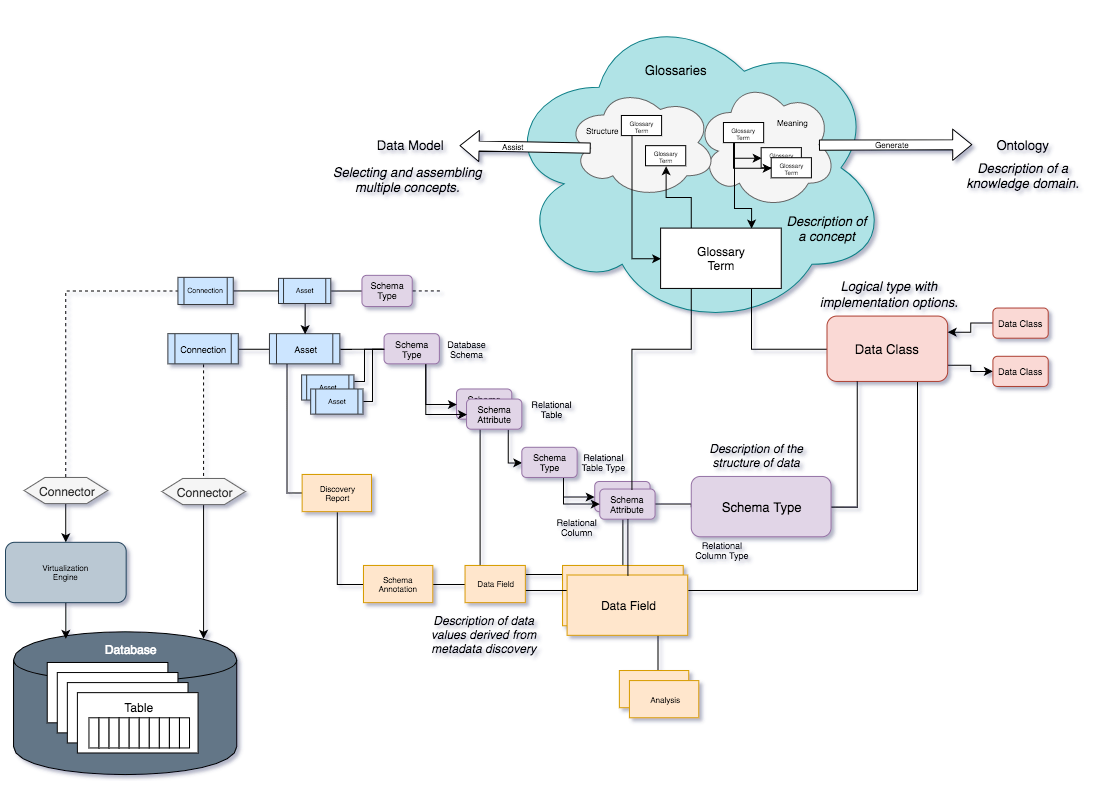

Thanks to Mandy for the above picture

The following cells create the larger (non-virtual) Asset and everything to the right and below it including the red DataClass instances. It does not create the GlossaryTerms (yet).

## Create Asset1, Asset2, Asset3

In [43]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","asset-qn001")
addStringProperty(instanceProperties,"name","asset-1")
addStringProperty(instanceProperties,"owner","owner-of-asset-1")
addStringProperty(instanceProperties,"description","Description of asset-1")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("Asset",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )
print("instanceCreateResponse:",instanceCreateResponse)

entity = instanceCreateResponse["entity"]
asset1_GUID = entity["guid"]
print("\n asset1_GUID",asset1_GUID)

instanceCreateResponse: {'class': 'EntityDetailResponse', 'relatedHTTPCode': 200, 'entity': {'class': 'EntityDetail', 'headerVersion': 1, 'type': {'class': 'InstanceType', 'typeDefCategory': 'ENTITY_DEF', 'typeDefGUID': '896d14c2-7522-4f6c-8519-757711943fe6', 'typeDefName': 'Asset', 'typeDefVersion': 1, 'typeDefDescription': 'The description of an asset that needs to be catalogued and governed.', 'typeDefSuperTypes': [{'headerVersion': 1, 'guid': 'a32316b8-dc8c-48c5-b12b-71c1b2a080bf', 'name': 'Referenceable', 'status': 'ACTIVE_TYPEDEF'}], 'validInstanceProperties': ['qualifiedName', 'additionalProperties', 'name', 'description', 'owner', 'ownerType', 'zoneMembership', 'latestChange']}, 'instanceProvenanceType': 'LOCAL_COHORT', 'metadataCollectionId': 'fee38e97-4bf3-4732-85b4-96bc58a80272', 'metadataCollectionName': 'Schema_Server', 'createdBy': 'garygeeke', 'createTime': '2020-04-01T16:15:09.070+0000', 'version': 1, 'guid': 'd4806ace-9c38-4201-8eb9-7b699fc3eacc', 'properties': {'class

In [44]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","asset-qn002")
addStringProperty(instanceProperties,"name","asset-2")
addStringProperty(instanceProperties,"owner","owner-of-asset-2")
addStringProperty(instanceProperties,"description","Description of asset-2")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("Asset",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )

entity = instanceCreateResponse["entity"]
asset2_GUID = entity["guid"]
print("\n asset2_GUID",asset2_GUID)


 asset2_GUID 72aeb5f0-543a-46bf-9aef-6e117d042262


In [45]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","asset-qn003")
addStringProperty(instanceProperties,"name","asset-3")
addStringProperty(instanceProperties,"owner","owner-of-asset-3")
addStringProperty(instanceProperties,"description","Description of asset-3")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("Asset",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )

entity = instanceCreateResponse["entity"]
asset3_GUID = entity["guid"]
print("\n asset3_GUID",asset3_GUID)


 asset3_GUID 30f96600-db59-472b-af03-c413d18ee4d5


## Create DatabaseSchema as a ComplexSchemaType

In [46]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","databaseschema-qn001")
addStringProperty(instanceProperties,"displayName","databaseschema-1")
addStringProperty(instanceProperties,"description","Database Schema 1")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("ComplexSchemaType",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

entity = instanceCreateResponse["entity"]
databaseSchema_GUID = entity["guid"]
print("\n databaseSchema_GUID",databaseSchema_GUID)


 databaseSchema_GUID 28c98743-9074-4517-8e3f-480381f5f717


## Relate DatabaseSchema with all three Assets (Asset1, Asset2, Asset3)

In [47]:
instanceCreateRequest = relationshipCreateRequestTemplate("AssetSchemaType",asset1_GUID,databaseSchema_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(schemaServer, instanceCreateRequest )

relationship = instanceCreateResponse["relationship"]
assetSchemaType1_GUID = relationship["guid"]
print("\n assetSchemaType1_GUID",assetSchemaType1_GUID)


 assetSchemaType1_GUID 00bedc01-9263-43a4-b06c-cf6e0ddaeb30


In [48]:
instanceCreateRequest = relationshipCreateRequestTemplate("AssetSchemaType",asset2_GUID,databaseSchema_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(schemaServer, instanceCreateRequest )

relationship = instanceCreateResponse["relationship"]
assetSchemaType2_GUID = relationship["guid"]
print("\n assetSchemaType2_GUID",assetSchemaType2_GUID)


 assetSchemaType2_GUID 53dd3610-96ec-47c4-880a-a5369400b577


In [49]:
instanceCreateRequest = relationshipCreateRequestTemplate("AssetSchemaType",asset3_GUID,databaseSchema_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(schemaServer, instanceCreateRequest )

relationship = instanceCreateResponse["relationship"]
assetSchemaType3_GUID = relationship["guid"]
print("\n assetSchemaType3_GUID",assetSchemaType3_GUID)


 assetSchemaType3_GUID 46f488e3-8630-4286-8896-02bd054549cc


## Create two RelationalTable SchemaAttributes

In [50]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","relationaltable-qn001")
addStringProperty(instanceProperties,"name","relationaltable-n1")
addStringProperty(instanceProperties,"displayName","relationaltable-1")
addStringProperty(instanceProperties,"description","Relational Table relationaltable-1")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("SchemaAttribute",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )

entity = instanceCreateResponse["entity"]
relationalTable1_GUID = entity["guid"]
print("\n relationalTable1_GUID",relationalTable1_GUID)


 relationalTable1_GUID d23789b9-819f-423b-bf65-f5cf80f62570


In [51]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","relationaltable-qn002")
addStringProperty(instanceProperties,"name","relationaltable-n2")
addStringProperty(instanceProperties,"displayName","relationaltable-2")
addStringProperty(instanceProperties,"description","Relational Table relationaltable-2")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("SchemaAttribute",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )

entity = instanceCreateResponse["entity"]
relationalTable2_GUID = entity["guid"]
print("\n relationalTable2_GUID",relationalTable2_GUID)


 relationalTable2_GUID 3e71b819-e592-481b-b471-186b8c84988e


## Relate the DatabaseSchema with RelationalTable1, RelationalTable2 

In [52]:
instanceCreateRequest = relationshipCreateRequestTemplate("AttributeForSchema",databaseSchema_GUID,relationalTable1_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(schemaServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

relationship = instanceCreateResponse["relationship"]
relationalTable1ForDatabaseSchema_GUID = relationship["guid"]
print("\n relationalTable1ForDatabaseSchema_GUID", relationalTable1ForDatabaseSchema_GUID)


 relationalTable1ForDatabaseSchema_GUID c23d5107-39a3-4378-8ad8-84bb12ec95cd


In [53]:
instanceCreateRequest = relationshipCreateRequestTemplate("AttributeForSchema",databaseSchema_GUID,relationalTable2_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(schemaServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

relationship = instanceCreateResponse["relationship"]
relationalTable2ForDatabaseSchema_GUID = relationship["guid"]
print("\n relationalTable2ForDatabaseSchema_GUID",relationalTable2ForDatabaseSchema_GUID)


 relationalTable2ForDatabaseSchema_GUID 8fa7bfe6-b3a4-49b5-8200-3143f17a6247


## Create RelationalTableTypes as ComplexSchemaTypes

In [54]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","relationaltabletype-qn001")
addStringProperty(instanceProperties,"displayName","relationaltabletype-1")
addStringProperty(instanceProperties,"description","Relational Table Type for RelationalTable1")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("ComplexSchemaType",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

entity = instanceCreateResponse["entity"]
relationalTableType1_GUID = entity["guid"]
print("\n relationalTableType1_GUID",relationalTableType1_GUID)


 relationalTableType1_GUID 502f06e1-1ff7-448a-bb2e-e40f55b29b5f


In [55]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","relationaltabletype-qn002")
addStringProperty(instanceProperties,"displayName","relationaltabletype-2")
addStringProperty(instanceProperties,"description","Relational Table Type for RelationalTable2")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("ComplexSchemaType",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

entity = instanceCreateResponse["entity"]
relationalTableType2_GUID = entity["guid"]
print("\n relationalTableType2_GUID",relationalTableType2_GUID)


 relationalTableType2_GUID bb1126d2-f320-4795-803d-151a7c3ebb17


## Relate RelationalTableType1 with RelationalTable1

In [56]:
instanceCreateRequest = relationshipCreateRequestTemplate("SchemaAttributeType",relationalTable1_GUID,relationalTableType1_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(schemaServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

relationship = instanceCreateResponse["relationship"]
relationalTableTypeForRelationalTable1_GUID = relationship["guid"]
print("\n relationalTableTypeForRelationalTable1_GUID",relationalTableTypeForRelationalTable1_GUID)


 relationalTableTypeForRelationalTable1_GUID 51ff9d49-8a86-4831-a6c6-75226af5e3f5


## Relate RelationalTableType2 with RelationalTable2

In [57]:
instanceCreateRequest = relationshipCreateRequestTemplate("SchemaAttributeType",relationalTable2_GUID,relationalTableType2_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(schemaServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

relationship = instanceCreateResponse["relationship"]
relationalTableTypeForRelationalTable2_GUID = relationship["guid"]
print("\n relationalTableTypeForRelationalTable2_GUID",relationalTableTypeForRelationalTable2_GUID)


 relationalTableTypeForRelationalTable2_GUID 17e371ea-9e00-45fc-8089-915d9db313ac


## For RelationalTableType1 create three Relational Columns (11, 12 and 13)

In [58]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","relationalColumn11-qname")
addStringProperty(instanceProperties,"name","relationalColumn11-name")
addStringProperty(instanceProperties,"displayName","relationalColumn11-displayName")
addStringProperty(instanceProperties,"description","Relational Column 11")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("SchemaAttribute",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )

entity = instanceCreateResponse["entity"]
relationalColumn11_GUID = entity["guid"]
print("\n relationalColumn11_GUID",relationalColumn11_GUID)


 relationalColumn11_GUID 3aa358cc-dd03-4882-964b-b9eb18e7e441


In [59]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","relationalColumn12-qname")
addStringProperty(instanceProperties,"name","relationalColumn12-name")
addStringProperty(instanceProperties,"displayName","relationalColumn12-displayName")
addStringProperty(instanceProperties,"description","Relational Column 12")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("SchemaAttribute",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )

entity = instanceCreateResponse["entity"]
relationalColumn12_GUID = entity["guid"]
print("\n relationalColumn12_GUID",relationalColumn12_GUID)


 relationalColumn12_GUID 1b99a577-c10f-4c71-84af-8d9de302cdbc


In [60]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","relationalColumn13-qname")
addStringProperty(instanceProperties,"name","relationalColumn13-name")
addStringProperty(instanceProperties,"displayName","relationalColumn13-displayName")
addStringProperty(instanceProperties,"description","Relational Column 13")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("SchemaAttribute",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )

entity = instanceCreateResponse["entity"]
relationalColumn13_GUID = entity["guid"]
print("\n relationalColumn13_GUID",relationalColumn13_GUID)


 relationalColumn13_GUID e3ed40fa-2199-4bf5-9a44-e77f7dc6145d


## Classify the Relational Columns

Relational Column 11 will have Retention classification (only).

Relational Column 12 will have Retention and Confidentiality classifications.

Relational Column 13 will have no classifications.

### Add a Confidentiality classification to Relational Column (12)

In [101]:
classificationProperties = propertiesBuilder()
# Proper line - addIntegerProperty(classificationProperties,"level",2)
# Test line below - 
addStringProperty(classificationProperties,"level","2")
addStringProperty(classificationProperties,"source","CorporateDirective-CD112")
addStringProperty(classificationProperties,"steward","data-sec-12345")
print("classificationProperties :", classificationProperties)

instancePropertiesRequest = instancePropertiesRequestTemplate(classificationProperties)

#classificationCreateRequest = classificationCreateRequestTemplate("Confidentiality",classificationProperties)
#print("classificationCreateRequest:",classificationCreateRequest)

classifyEntityResponse = classifyEntity(schemaServer, relationalColumn12_GUID, "Confidentiality", instancePropertiesRequest)
print("classifyEntityResponse:",classifyEntityResponse)

#classification = classifyEntityResponse["classification"]
#relationalColumn11_GUID = entity["guid"]
#print("\n relationalColumn11_GUID",relationalColumn11_GUID)
#print("\n classification is ... ",classification)

classificationProperties : {'class': 'InstanceProperties', 'instanceProperties': {'level': {'class': 'PrimitivePropertyValue', 'instancePropertyCategory': 'PRIMITIVE', 'primitiveDefCategory': 'OM_PRIMITIVE_TYPE_STRING', 'primitiveValue': '2'}, 'source': {'class': 'PrimitivePropertyValue', 'instancePropertyCategory': 'PRIMITIVE', 'primitiveDefCategory': 'OM_PRIMITIVE_TYPE_STRING', 'primitiveValue': 'CorporateDirective-CD112'}, 'steward': {'class': 'PrimitivePropertyValue', 'instancePropertyCategory': 'PRIMITIVE', 'primitiveDefCategory': 'OM_PRIMITIVE_TYPE_STRING', 'primitiveValue': 'data-sec-12345'}}, 'propertyNames': ['level', 'source', 'steward'], 'propertyCount': 3}
classifyEntityResponse: {'class': 'EntityDetailResponse', 'relatedHTTPCode': 400, 'actionDescription': 'classifyEntity', 'exceptionErrorMessage': 'OMRS-REPOSITORY-400-030 A property called level of type Primitive has been proposed for a new metadata instance of category ClassificationDef and type Confidentiality; this pro

### Add a Retention classification to Relational Columns (11 and 12)

In [62]:
classificationProperties = propertiesBuilder()
addStringProperty(classificationProperties,"notes","Data to be retained for 24 months")
addStringProperty(classificationProperties,"source","CorporateDirective-CD109")
addStringProperty(classificationProperties,"steward","data-records-007")
print("classificationProperties :", classificationProperties)

instancePropertiesRequest = instancePropertiesRequestTemplate(classificationProperties)

classifyEntityResponse = classifyEntity(schemaServer, relationalColumn11_GUID, "Retention", instancePropertiesRequest)
#print("\n classifyEntityResponse:",classifyEntityResponse)

classifyEntityResponse = classifyEntity(schemaServer, relationalColumn12_GUID, "Retention", instancePropertiesRequest)
#print("\n classifyEntityResponse:",classifyEntityResponse)

classificationProperties : {'class': 'InstanceProperties', 'instanceProperties': {'notes': {'class': 'PrimitivePropertyValue', 'instancePropertyCategory': 'PRIMITIVE', 'primitiveDefCategory': 'OM_PRIMITIVE_TYPE_STRING', 'primitiveValue': 'Data to be retained for 24 months'}, 'source': {'class': 'PrimitivePropertyValue', 'instancePropertyCategory': 'PRIMITIVE', 'primitiveDefCategory': 'OM_PRIMITIVE_TYPE_STRING', 'primitiveValue': 'CorporateDirective-CD109'}, 'steward': {'class': 'PrimitivePropertyValue', 'instancePropertyCategory': 'PRIMITIVE', 'primitiveDefCategory': 'OM_PRIMITIVE_TYPE_STRING', 'primitiveValue': 'data-records-007'}}, 'propertyNames': ['notes', 'source', 'steward'], 'propertyCount': 3}


## Relate RelationalColumns 11, 12 and 13 to RelationalTableType1


In [63]:
instanceCreateRequest = relationshipCreateRequestTemplate("AttributeForSchema",relationalTableType1_GUID,relationalColumn11_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(schemaServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

relationship = instanceCreateResponse["relationship"]
relationalColumn11ForRelationalTableType1_GUID = relationship["guid"]
print("\n relationalColumn11ForRelationalTableType1_GUID",relationalColumn11ForRelationalTableType1_GUID)


 relationalColumn11ForRelationalTableType1_GUID d5862679-3566-47bc-ae02-b4e5642115ff


In [64]:
instanceCreateRequest = relationshipCreateRequestTemplate("AttributeForSchema",relationalTableType1_GUID,relationalColumn12_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(schemaServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

relationship = instanceCreateResponse["relationship"]
relationalColumn12ForRelationalTableType1_GUID = relationship["guid"]
print("\n relationalColumn12ForRelationalTableType1_GUID",relationalColumn12ForRelationalTableType1_GUID)


 relationalColumn12ForRelationalTableType1_GUID 671e4aac-cc6a-498f-933f-0907958fd0f0


In [65]:
instanceCreateRequest = relationshipCreateRequestTemplate("AttributeForSchema",relationalTableType1_GUID,relationalColumn13_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(schemaServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

relationship = instanceCreateResponse["relationship"]
relationalColumn13ForRelationalTableType1_GUID = relationship["guid"]
print("\n relationalColumn13ForRelationalTableType1_GUID",relationalColumn13ForRelationalTableType1_GUID)


 relationalColumn13ForRelationalTableType1_GUID f726f26f-2b99-4745-baa9-135668f0e43a


## For RelationalTableType2 create two Relational Columns (21 and 22)

In [66]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","relationalColumn21-qname")
addStringProperty(instanceProperties,"name","relationalColumn21-name")
addStringProperty(instanceProperties,"displayName","relationalColumn21-displayName")
addStringProperty(instanceProperties,"description","Relational Column 21")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("SchemaAttribute",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )

entity = instanceCreateResponse["entity"]
relationalColumn21_GUID = entity["guid"]
print("\n relationalColumn21_GUID",relationalColumn21_GUID)


 relationalColumn21_GUID d4cc8a91-a17c-46cb-ab60-6162ebe3e398


In [67]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","relationalColumn22-qname")
addStringProperty(instanceProperties,"name","relationalColumn22-name")
addStringProperty(instanceProperties,"displayName","relationalColumn22-displayName")
addStringProperty(instanceProperties,"description","Relational Column 22")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("SchemaAttribute",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )

entity = instanceCreateResponse["entity"]
relationalColumn22_GUID = entity["guid"]
print("\n relationalColumn22_GUID",relationalColumn22_GUID)


 relationalColumn22_GUID dfd5a3fb-747b-4894-a6d1-4b983eaf6f0a


## Relate RelationalColumn21, RelationalColumn22 with RelationalTableType2


In [68]:
instanceCreateRequest = relationshipCreateRequestTemplate("AttributeForSchema",relationalTableType2_GUID,relationalColumn21_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(schemaServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

relationship = instanceCreateResponse["relationship"]
relationalColumn21ForRelationalTableType2_GUID = relationship["guid"]
print("\n relationalColumn21ForRelationalTableType2_GUID",relationalColumn21ForRelationalTableType2_GUID)


 relationalColumn21ForRelationalTableType2_GUID 25fcaa74-4a23-414e-9d14-af7157084c07


In [69]:
instanceCreateRequest = relationshipCreateRequestTemplate("AttributeForSchema",relationalTableType2_GUID,relationalColumn22_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(schemaServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

relationship = instanceCreateResponse["relationship"]
relationalColumn22ForRelationalTableType2_GUID = relationship["guid"]
print("\n relationalColumn22ForRelationalTableType2_GUID",relationalColumn22ForRelationalTableType2_GUID)


 relationalColumn22ForRelationalTableType2_GUID e483d920-9377-40de-af24-692428090ef4


## For RelationalColumn11 create a RelationalColumnType

In [70]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","relationalColumnType11-qname")
addStringProperty(instanceProperties,"displayName","relationalColumnType11-displayName")
addStringProperty(instanceProperties,"description","Relational Column Type for RelationalColumn11")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("SchemaType",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

entity = instanceCreateResponse["entity"]
relationalColumnType11_GUID = entity["guid"]
print("\n relationalColumnType11_GUID",relationalColumnType11_GUID)


 relationalColumnType11_GUID c51fa7a5-9707-4c7c-a430-84a92ce64f93


## Relate RelationalColumn11 and RelationalColumnType11

In [71]:
instanceCreateRequest = relationshipCreateRequestTemplate("SchemaAttributeType",relationalColumn11_GUID,relationalColumnType11_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(schemaServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

relationship = instanceCreateResponse["relationship"]
relationalColumnType11ForRelationalColumn11_GUID = relationship["guid"]
print("\n relationalColumnType11ForRelationalColumn11_GUID",relationalColumnType11ForRelationalColumn11_GUID)


 relationalColumnType11ForRelationalColumn11_GUID 8fc9e93d-7f33-4355-9930-022bb3ff8b7e


## For RelationalColumn12 create a RelationalColumnType

In [72]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","relationalColumnType12-qname")
addStringProperty(instanceProperties,"displayName","relationalColumnType12-displayName")
addStringProperty(instanceProperties,"description","Relational Column Type for RelationalColumn12")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("SchemaType",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

entity = instanceCreateResponse["entity"]
relationalColumnType12_GUID = entity["guid"]
print("\n relationalColumnType12_GUID",relationalColumnType12_GUID)


 relationalColumnType12_GUID 2f0c2886-7d8b-453d-9f88-06c2490807af


## Relate RelationalColumn12 and RelationalColumnType12

In [73]:
instanceCreateRequest = relationshipCreateRequestTemplate("SchemaAttributeType",relationalColumn12_GUID,relationalColumnType12_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(schemaServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

relationship = instanceCreateResponse["relationship"]
relationalColumnType12ForRelationalColumn12_GUID = relationship["guid"]
print("\n relationalColumnType12ForRelationalColumn12_GUID",relationalColumnType12ForRelationalColumn12_GUID)


 relationalColumnType12ForRelationalColumn12_GUID 10f57055-c28c-463e-b45f-730b3fcee648


## For RelationalColumn21 create a RelationalColumnType

In [74]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","relationalColumnType21-qname")
addStringProperty(instanceProperties,"displayName","relationalColumnType21-displayName")
addStringProperty(instanceProperties,"description","Relational Column Type for RelationalColumn21")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("SchemaType",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

entity = instanceCreateResponse["entity"]
relationalColumnType21_GUID = entity["guid"]
print("\n relationalColumnType21_GUID",relationalColumnType21_GUID)


 relationalColumnType21_GUID 5b4315d9-b636-48c8-b2ba-2a3994027b4a


## Relate RelationalColumn21 and RelationalColumnType21

In [75]:
instanceCreateRequest = relationshipCreateRequestTemplate("SchemaAttributeType",relationalColumn21_GUID,relationalColumnType21_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(schemaServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

relationship = instanceCreateResponse["relationship"]
relationalColumnType21ForRelationalColumn21_GUID = relationship["guid"]
print("\n relationalColumnType21ForRelationalColumn21_GUID",relationalColumnType21ForRelationalColumn21_GUID)


 relationalColumnType21ForRelationalColumn21_GUID 75256fe8-bd24-4bab-9c5e-a2a44912a7b7


## For RelationalColumn22 create a RelationalColumnType

In [76]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","relationalColumnType22-qname")
addStringProperty(instanceProperties,"displayName","relationalColumnType22-displayName")
addStringProperty(instanceProperties,"description","Relational Column Type for RelationalColumn22")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("SchemaType",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(schemaServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

entity = instanceCreateResponse["entity"]
relationalColumnType22_GUID = entity["guid"]
print("\n relationalColumnType22_GUID",relationalColumnType22_GUID)


 relationalColumnType22_GUID 06237a69-3984-4b3c-b571-ab0ee1953ea2


## Relate RelationalColumn22 and RelationalColumnType22

In [77]:
instanceCreateRequest = relationshipCreateRequestTemplate("SchemaAttributeType",relationalColumn22_GUID,relationalColumnType22_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(schemaServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

relationship = instanceCreateResponse["relationship"]
relationalColumnType22ForRelationalColumn22_GUID = relationship["guid"]
print("\n relationalColumnType22ForRelationalColumn22_GUID",relationalColumnType22ForRelationalColumn22_GUID)


 relationalColumnType22ForRelationalColumn22_GUID 86b7bca6-5bc6-4480-9eed-1d52898a4d99


# Add the Discovery Report and Annotations...

### Add a DiscoveryReport to Asset1

In [78]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"qualifiedName","discoveryReport1-qname")
addStringProperty(instanceProperties,"displayName","discoveryReport1-displayName")
addStringProperty(instanceProperties,"description","Discovery Analysis Report for Asset1")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("OpenDiscoveryAnalysisReport",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(reportServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

entity = instanceCreateResponse["entity"]
discoveryReport1_GUID = entity["guid"]
print("\n discoveryReport1_GUID",discoveryReport1_GUID)


 discoveryReport1_GUID 08490283-a24e-49f9-8e21-7f179a23b42b


In [80]:
instanceCreateRequest = relationshipCreateRequestTemplate("AssetDiscoveryReport",asset1_GUID,discoveryReport1_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(schemaServer, instanceCreateRequest )
print("instanceCreateResponse:",instanceCreateResponse)

relationship = instanceCreateResponse["relationship"]
discoveryReportForAsset1_GUID = relationship["guid"]
print("\n discoveryReportForAsset1_GUID",discoveryReportForAsset1_GUID)

instanceCreateResponse: {'class': 'RelationshipResponse', 'relatedHTTPCode': 200, 'relationship': {'class': 'Relationship', 'headerVersion': 1, 'type': {'class': 'InstanceType', 'typeDefCategory': 'RELATIONSHIP_DEF', 'typeDefGUID': '7eded424-f176-4258-9ae6-138a46b2845f', 'typeDefName': 'AssetDiscoveryReport', 'typeDefVersion': 1, 'typeDefDescription': 'An analysis report from a discovery service.'}, 'instanceProvenanceType': 'LOCAL_COHORT', 'metadataCollectionId': 'fee38e97-4bf3-4732-85b4-96bc58a80272', 'metadataCollectionName': 'Schema_Server', 'createdBy': 'garygeeke', 'createTime': '2020-04-01T16:15:45.257+0000', 'version': 1, 'guid': '97863fd8-c8ca-4281-8f47-b4c62447013e', 'entityOneProxy': {'class': 'EntityProxy', 'headerVersion': 0, 'type': {'class': 'InstanceType', 'typeDefCategory': 'ENTITY_DEF', 'typeDefGUID': '896d14c2-7522-4f6c-8519-757711943fe6', 'typeDefName': 'Asset', 'typeDefVersion': 1, 'typeDefDescription': 'The description of an asset that needs to be catalogued and g

### Add a SchemaAnnotation to the DiscoveryReport

In [81]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"explanation","schemaAnalysisAnnotation1-explanation")
addStringProperty(instanceProperties,"schemaName","schemaName-databaseSchema")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("SchemaAnalysisAnnotation",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(reportServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

entity = instanceCreateResponse["entity"]
schemaAnalysisAnnotation1_GUID = entity["guid"]
print("\n schemaAnalysisAnnotation1_GUID",schemaAnalysisAnnotation1_GUID)


 schemaAnalysisAnnotation1_GUID fd65efcc-4dfd-48c4-a70d-88f81e93aa0a


In [82]:
instanceCreateRequest = relationshipCreateRequestTemplate("DiscoveredAnnotation",schemaAnalysisAnnotation1_GUID,discoveryReport1_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(reportServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

relationship = instanceCreateResponse["relationship"]
discoveredAnnotation1ForDiscoveryReport_GUID = relationship["guid"]
print("\n discoveredAnnotation1ForDiscoveryReport_GUID",discoveredAnnotation1ForDiscoveryReport_GUID)


 discoveredAnnotation1ForDiscoveryReport_GUID 6f515a7b-a09a-431e-bb3e-7f317921d388


### Add a DataField that will relate to the RelationalTable

In [83]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"dataFieldName","dataFieldForRelationalTable1-name")
addStringProperty(instanceProperties,"dataFieldDescription","dataFieldForRelationalTable1-description")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("DataField",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(reportServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

entity = instanceCreateResponse["entity"]
dataFieldForRelationalTable1_GUID = entity["guid"]
print("\n dataFieldForRelationalTable1_GUID",dataFieldForRelationalTable1_GUID)


 dataFieldForRelationalTable1_GUID 1d51a75f-1053-4824-8cd0-73c7f8466df0


Associate the DataField with the SchemaAnalysisAnnotation

In [84]:
instanceCreateRequest = relationshipCreateRequestTemplate("DiscoveredDataField",schemaAnalysisAnnotation1_GUID,dataFieldForRelationalTable1_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(reportServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

relationship = instanceCreateResponse["relationship"]
discoveredDataFieldForRelationalTable1_GUID = relationship["guid"]
print("\n discoveredDataFieldForRelationalTable1_GUID", discoveredDataFieldForRelationalTable1_GUID)


 discoveredDataFieldForRelationalTable1_GUID 434c6f73-30ab-4f09-88fc-0b53917f6f38


Associate the DataField with the RelationalTable

In [85]:
instanceCreateRequest = relationshipCreateRequestTemplate("SchemaAttributeDefinition",dataFieldForRelationalTable1_GUID,relationalTable1_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(reportServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

relationship = instanceCreateResponse["relationship"]
schemaAttributeDefinitionForRelationalTable1_GUID = relationship["guid"]
print("\n schemaAttributeDefinitionForRelationalTable1_GUID", schemaAttributeDefinitionForRelationalTable1_GUID)


 schemaAttributeDefinitionForRelationalTable1_GUID 966fccd6-a71c-4e6a-9a3c-f5aaf5525227


### Add a DataField for each RelationalColumn in RelationalTable1

In [86]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"dataFieldName","dataFieldForRelationalColumn11-name")
addStringProperty(instanceProperties,"dataFieldDescription","dataFieldForRelationalColumn11-description")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("DataField",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(reportServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

entity = instanceCreateResponse["entity"]
dataFieldForRelationalColumn11_GUID = entity["guid"]
print("\n dataFieldForRelationalColumn11_GUID",dataFieldForRelationalColumn11_GUID)


 dataFieldForRelationalColumn11_GUID 21214c7f-323a-4896-b06e-199e4f15b773


In [87]:
instanceCreateRequest = relationshipCreateRequestTemplate("DiscoveredNestedDataField",dataFieldForRelationalTable1_GUID,dataFieldForRelationalColumn11_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(reportServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

relationship = instanceCreateResponse["relationship"]
discoveredNestedDataFieldForRelationalColumn11_GUID = relationship["guid"]
print("\n discoveredNestedDataFieldForRelationalColumn11_GUID", discoveredNestedDataFieldForRelationalColumn11_GUID)


 discoveredNestedDataFieldForRelationalColumn11_GUID aa4d4464-1967-42d4-8218-59cbc487ccde


In [88]:
instanceCreateRequest = relationshipCreateRequestTemplate("SchemaAttributeDefinition",dataFieldForRelationalColumn11_GUID,relationalColumn11_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(reportServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

relationship = instanceCreateResponse["relationship"]
schemaAttributeDefinitionForRelationalColumn11_GUID = relationship["guid"]
print("\n schemaAttributeDefinitionForRelationalColumn11_GUID", schemaAttributeDefinitionForRelationalColumn11_GUID)


 schemaAttributeDefinitionForRelationalColumn11_GUID c9dd88db-ef58-43c6-ab3c-d28786f10df6


In [89]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"dataFieldName","dataFieldForRelationalColumn12-name")
addStringProperty(instanceProperties,"dataFieldDescription","dataFieldForRelationalColumn12-description")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("DataField",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(reportServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

entity = instanceCreateResponse["entity"]
dataFieldForRelationalColumn12_GUID = entity["guid"]
print("\n dataFieldForRelationalColumn12_GUID",dataFieldForRelationalColumn12_GUID)


 dataFieldForRelationalColumn12_GUID 0168d496-9de0-4fb0-aa36-1cea3f0e41db


In [90]:
instanceCreateRequest = relationshipCreateRequestTemplate("DiscoveredNestedDataField",dataFieldForRelationalTable1_GUID,dataFieldForRelationalColumn12_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(reportServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

relationship = instanceCreateResponse["relationship"]
discoveredNestedDataFieldForRelationalColumn12_GUID = relationship["guid"]
print("\n discoveredNestedDataFieldForRelationalColumn12_GUID", discoveredNestedDataFieldForRelationalColumn12_GUID)


 discoveredNestedDataFieldForRelationalColumn12_GUID 89872816-2dbe-49d8-b4fa-ea96822b80df


In [91]:
instanceCreateRequest = relationshipCreateRequestTemplate("SchemaAttributeDefinition",dataFieldForRelationalColumn12_GUID,relationalColumn12_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(reportServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

relationship = instanceCreateResponse["relationship"]
schemaAttributeDefinitionForRelationalColumn12_GUID = relationship["guid"]
print("\n schemaAttributeDefinitionForRelationalColumn12_GUID", schemaAttributeDefinitionForRelationalColumn12_GUID)


 schemaAttributeDefinitionForRelationalColumn12_GUID 74bb6bbf-6c72-49df-9684-ab0d7b518236


### Add an Annotation for each DataField for each RelationalColumn in RelationalTable1

In [92]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"expression","dataFieldAnnotationForRelationalColumn11-expression")
addStringProperty(instanceProperties,"explanation","dataFieldAnnotationForRelationalColumn11-explanation")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("DataFieldAnnotation",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(reportServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

entity = instanceCreateResponse["entity"]
dataFieldAnnotationForRelationalColumn11_GUID = entity["guid"]
print("\n dataFieldAnnotationForRelationalColumn11_GUID", dataFieldAnnotationForRelationalColumn11_GUID)


 dataFieldAnnotationForRelationalColumn11_GUID 0a469195-37f4-45ab-93ca-3cf91831feaa


In [93]:
instanceCreateRequest = relationshipCreateRequestTemplate("DataFieldAnalysis",dataFieldAnnotationForRelationalColumn11_GUID,dataFieldForRelationalColumn11_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(reportServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

relationship = instanceCreateResponse["relationship"]
dataFieldAnalysisForAnnotationForRelationalColumn11_GUID = relationship["guid"]
print("\n dataFieldAnalysisForAnnotationForRelationalColumn11_GUID", dataFieldAnalysisForAnnotationForRelationalColumn11_GUID)


 dataFieldAnalysisForAnnotationForRelationalColumn11_GUID 2998a540-b683-4cfa-a1ed-fd4b9b5a9cfb


In [94]:
instanceProperties = propertiesBuilder()
addStringProperty(instanceProperties,"expression","dataFieldAnnotationForRelationalColumn12-expression")
addStringProperty(instanceProperties,"explanation","dataFieldAnnotationForRelationalColumn12-explanation")
#print("processProperties :", processProperties)
instanceCreateRequest = entityCreateRequestTemplate("DataFieldAnnotation",instanceProperties)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createEntity(reportServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

entity = instanceCreateResponse["entity"]
dataFieldAnnotationForRelationalColumn12_GUID = entity["guid"]
print("\n dataFieldAnnotationForRelationalColumn12_GUID", dataFieldAnnotationForRelationalColumn12_GUID)


 dataFieldAnnotationForRelationalColumn12_GUID 319e27d5-3a67-4040-a823-391170c39cd8


In [95]:
instanceCreateRequest = relationshipCreateRequestTemplate("DataFieldAnalysis",dataFieldAnnotationForRelationalColumn12_GUID,dataFieldForRelationalColumn12_GUID,None)
#print("instanceCreateRequest:",instanceCreateRequest)

instanceCreateResponse = createRelationship(reportServer, instanceCreateRequest )
#print("instanceCreateResponse:",instanceCreateResponse)

relationship = instanceCreateResponse["relationship"]
dataFieldAnalysisForAnnotationForRelationalColumn12_GUID = relationship["guid"]
print("\n dataFieldAnalysisForAnnotationForRelationalColumn12_GUID", dataFieldAnalysisForAnnotationForRelationalColumn12_GUID)


 dataFieldAnalysisForAnnotationForRelationalColumn12_GUID e288494f-3b4c-487c-918a-5b91b3212f20
